<a href="https://colab.research.google.com/github/Musbell/Person-Detection-Detectron2-./blob/master/Person_Detection_(Detectron2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
     |████████████████████████████████| 276kB 8.4MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=ef904abe71d8d55a1f33fd94a58d6f74283e7edafd35fa7759c78256d56a65cc
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-fyzzwvfs
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-fyzzwvfs
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-lin

In [0]:
# install detectron2:
!pip install detectron2==0.1.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html


In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()


# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow
from pycocotools.coco import COCO
import os
import skimage.io as io
import pandas as pd
import urllib
import json
import PIL.Image as Image
import random

### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [0]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip 
!rm annotations_trainval2017.zip

--2020-05-12 10:17:29--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.139.43
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.139.43|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  34.3MB/s    in 7.6s    

2020-05-12 10:17:37 (31.6 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [0]:
dataDir=os.getcwd()
dataType='val'
annFile='{}/annotations/instances_{}2017.json'.format(dataDir,dataType)

# initialize the COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.57s)
creating index...
index created!


In [0]:
# display COCO categories and supercategories
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

nms=[cat['name'] for cat in cats]
print(len(nms),'COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print(len(nms),'COCO supercategories: \n{}'.format(' '.join(nms)))

80 COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

12 COCO supercategories: 
vehicle sports kitchen accessory appliance animal electronic indoor furniture person food outdoor


In [0]:
# Observe how the ids range from 0 to 90
cats

[{'id': 1, 'name': 'person', 'supercategory': 'person'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'vehicle'},
 {'id': 3, 'name': 'car', 'supercategory': 'vehicle'},
 {'id': 4, 'name': 'motorcycle', 'supercategory': 'vehicle'},
 {'id': 5, 'name': 'airplane', 'supercategory': 'vehicle'},
 {'id': 6, 'name': 'bus', 'supercategory': 'vehicle'},
 {'id': 7, 'name': 'train', 'supercategory': 'vehicle'},
 {'id': 8, 'name': 'truck', 'supercategory': 'vehicle'},
 {'id': 9, 'name': 'boat', 'supercategory': 'vehicle'},
 {'id': 10, 'name': 'traffic light', 'supercategory': 'outdoor'},
 {'id': 11, 'name': 'fire hydrant', 'supercategory': 'outdoor'},
 {'id': 13, 'name': 'stop sign', 'supercategory': 'outdoor'},
 {'id': 14, 'name': 'parking meter', 'supercategory': 'outdoor'},
 {'id': 15, 'name': 'bench', 'supercategory': 'outdoor'},
 {'id': 16, 'name': 'bird', 'supercategory': 'animal'},
 {'id': 17, 'name': 'cat', 'supercategory': 'animal'},
 {'id': 18, 'name': 'dog', 'supercategory': 'animal'},

In [0]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

print('The class name is', getClassName(1, cats))

The class name is person


In [0]:
# get all images containing given categories, select one at random
filterClasses = ['person']
catIds = coco.getCatIds(catNms=filterClasses);
imgIds = coco.getImgIds(catIds=catIds);

print("Number of images containing all required classes:", len(imgIds))

Number of images containing all required classes: 2693


In [0]:
def filterDataset(folder, classes=None, mode='train'):    
    # initialize COCO api for instance annotations
    annFile = '{}/annotations/instances_{}2017.json'.format(folder, mode)
    coco = COCO(annFile)
    
    images = []
    annotations = []
    categories = []

    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            annIds = coco.getAnnIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
            annotations += coco.loadAnns(annIds)
            categories  += coco.loadCats(catIds)
    
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
        annotations = coco.loadAnns(annIds)
        categories  = coco.loadCats(catIds)
    
    # Now, filter out the repeated images
    unique_images = []
    unique_annotations = []
    unique_categories = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])

    for i in range(len(annotations)):
        if annotations[i] not in unique_annotations:
            unique_annotations.append(annotations[i])
    
    for i in range(len(categories)):
        if categories[i] not in unique_categories:
            unique_categories.append(categories[i])
            
    random.shuffle(unique_images)
    random.shuffle(unique_annotations)
    random.shuffle(unique_categories)
    dataset_size = len(unique_images)
    ann_dataset_size = len(unique_annotations)
    categories_dataset_size = len(unique_categories)
    
    return unique_images, unique_annotations, unique_categories, ann_dataset_size, dataset_size, categories_dataset_size, coco

In [0]:
folder = os.getcwd()
classes = ['person']
mode = 'val'

unique_images, unique_annotations, unique_categories, ann_dataset_size, dataset_size, categories_dataset_size, coco = filterDataset(folder, classes,  mode)

loading annotations into memory...
Done (t=0.70s)
creating index...
index created!


In [0]:
unique_categories

[{'id': 1, 'name': 'person', 'supercategory': 'person'}]

In [0]:
import json

person_annotations = {'annotations': unique_annotations, 'images': unique_images, 'categories': unique_categories}

with open('person_annotations.json', 'w') as json_file:
  json.dump(person_annotations, json_file)

In [0]:
!mkdir images 
!cd images && mkdir train && mkdir val

In [0]:
# Download images

for image in unique_images:
  img = urllib.request.urlopen(image["coco_url"])
  img = Image.open(img)
  img = img.convert('RGB')
    

  image_name = image["file_name"]
  img.save(f'images/{mode}/{image_name}', "JPEG")

In [0]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return None

def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img
    
def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        pixel_value = classes.index(className)+1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask  
    
def getBinaryMask(imageObj, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)
        
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0

        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask


def dataGeneratorCoco(images, classes, coco, folder, 
                      input_image_size=(224,224), batch_size=4, mode='train', mask_type='binary'):
    
    img_folder = '{}/images/{}'.format(folder, mode)
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    
    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, img_folder, input_image_size)
            
            ### Create Mask ###
            if mask_type=="binary":
                train_mask = getBinaryMask(imageObj, coco, catIds, input_image_size)
            
            elif mask_type=="normal":
                train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask

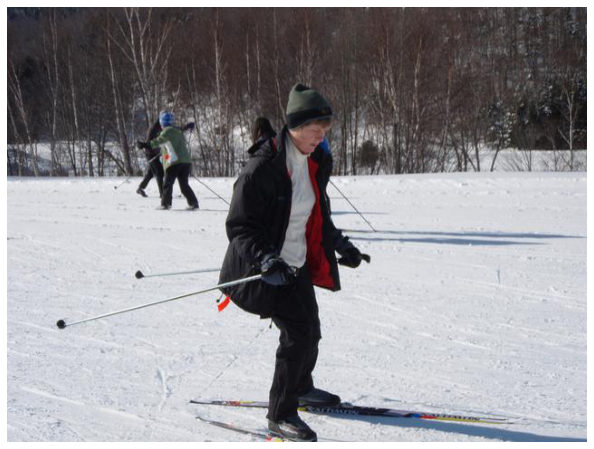

In [0]:
# load and display image
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
I = io.imread('{}/images/{}/{}'.format(dataDir,dataType,img['file_name']))/255.0
# Or use url to load image
# I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

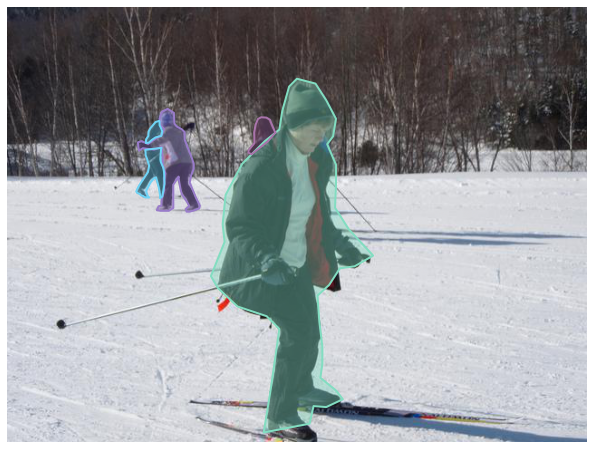

In [0]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

Unique pixel values in the mask are: [0. 1.]


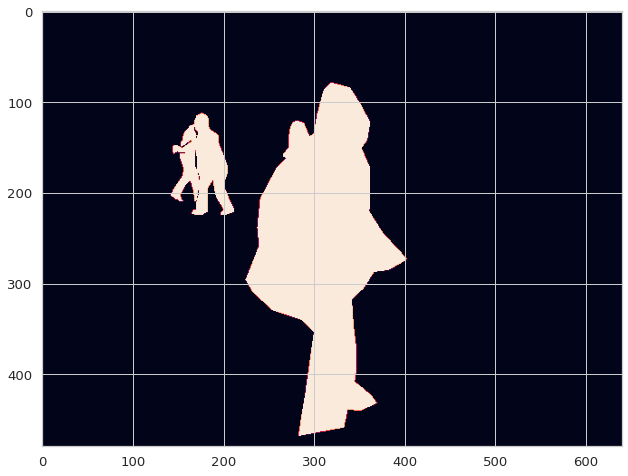

In [0]:
#### GENERATE A SEGMENTATION MASK ####
filterClasses = ['person']
mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    className = getClassName(anns[i]['category_id'], cats)
    pixel_value = filterClasses.index(className)+1
    mask = np.maximum(coco.annToMask(anns[i])*pixel_value, mask)
plt.imshow(mask)

print('Unique pixel values in the mask are:', np.unique(mask))

Unique pixel values in the mask are: [0. 1.]


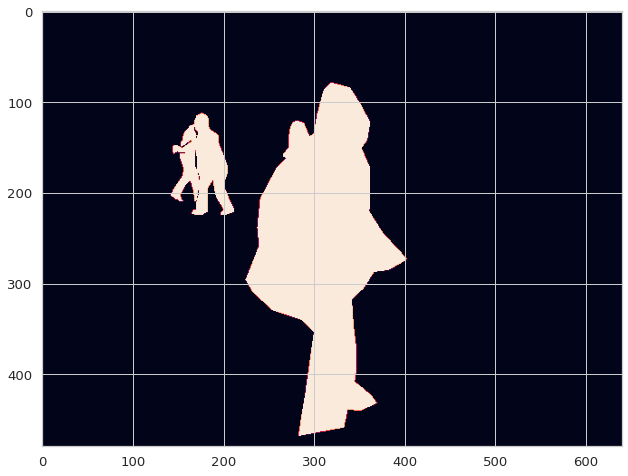

In [0]:
#### GENERATE BINARY MASK ####

mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    mask = np.maximum(coco.annToMask(anns[i]), mask)
plt.imshow(mask)

print('Unique pixel values in the mask are:', np.unique(mask))

In [0]:
batch_size = 4
input_image_size = (224,224)
mask_type = 'normal'

val_gen = dataGeneratorCoco(unique_images, classes, coco, folder,
                            input_image_size, batch_size, mode, mask_type)

In [0]:
def visualizeGenerator(gen):
    img, mask = next(gen)
    
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
    
    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j])
            else:
                ax.imshow(mask[j][:,:,0])
                
            ax.axis('off')
            fig.add_subplot(ax)        
    plt.show()

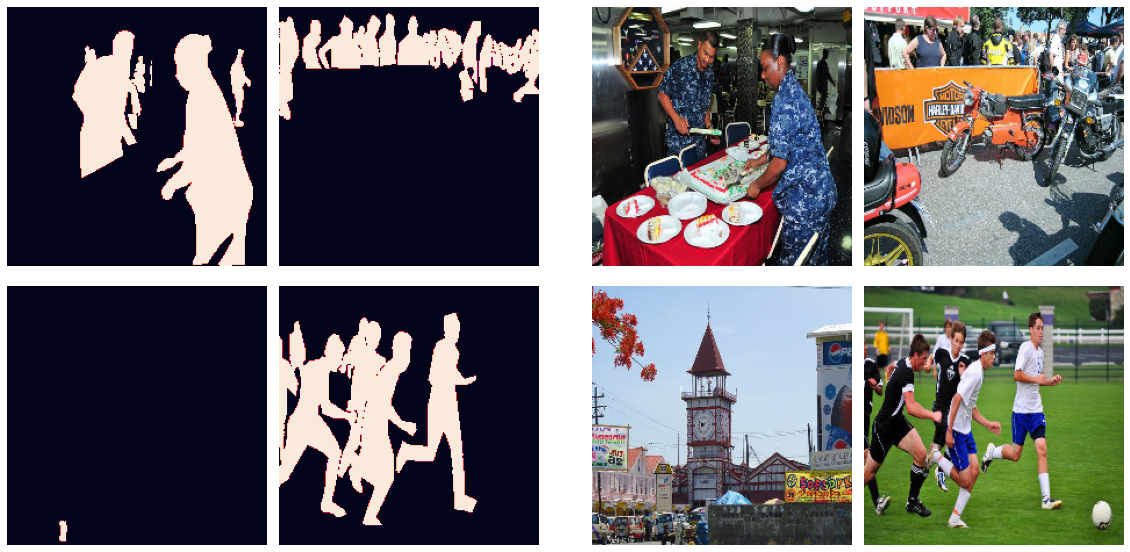

In [0]:
visualizeGenerator(val_gen)

In [0]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("df_persons", {}, "/content/person_annotations.json", "/content/images/val")

In [0]:
person_metadata = MetadataCatalog.get("df_persons")
person_metadata

Metadata(evaluator_type='coco', image_root='/content/images/val', json_file='/content/person_annotations.json', name='df_persons')

In [0]:
dataset_dicts = DatasetCatalog.get("df_persons")

[05/12 10:42:14 d2.data.datasets.coco]: Loaded 2693 images in COCO format from /content/person_annotations.json


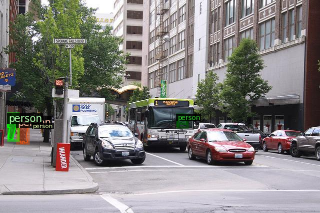

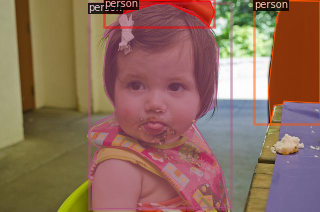

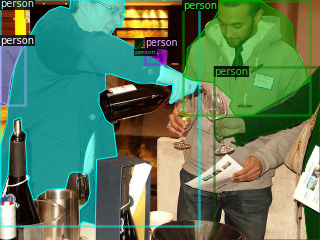

In [0]:
import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=person_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("df_persons",)
cfg.DATASETS.TEST = ()  # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05
cfg.SOLVER.MAX_ITER = (
    500
)  # 300 iterations seems good enough, but you can certainly train longer

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)

cfg.TEST.EVAL_PERIOD = 500

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[05/12 10:42:25 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:18, 9.85MB/s]                           
'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (1,) in the model! Skipped.


[05/12 10:42:51 d2.engine.train_loop]: Starting training from iteration 0
[05/12 10:43:02 d2.utils.events]:  eta: 0:04:21  iter: 19  total_loss: 2.363  loss_cls: 0.708  loss_box_reg: 0.882  loss_mask: 0.696  loss_rpn_cls: 0.018  loss_rpn_loc: 0.024  time: 0.5398  data_time: 0.0477  lr: 0.000020  max_mem: 4993M
[05/12 10:43:13 d2.utils.events]:  eta: 0:04:11  iter: 39  total_loss: 2.246  loss_cls: 0.617  loss_box_reg: 0.891  loss_mask: 0.684  loss_rpn_cls: 0.032  loss_rpn_loc: 0.026  time: 0.5428  data_time: 0.0261  lr: 0.000040  max_mem: 4993M
[05/12 10:43:25 d2.utils.events]:  eta: 0:04:03  iter: 59  total_loss: 2.089  loss_cls: 0.500  loss_box_reg: 0.854  loss_mask: 0.659  loss_rpn_cls: 0.033  loss_rpn_loc: 0.027  time: 0.5511  data_time: 0.0240  lr: 0.000060  max_mem: 4993M
[05/12 10:43:36 d2.utils.events]:  eta: 0:03:55  iter: 79  total_loss: 1.960  loss_cls: 0.412  loss_box_reg: 0.854  loss_mask: 0.620  loss_rpn_cls: 0.028  loss_rpn_loc: 0.016  time: 0.5556  data_time: 0.0216  lr:

In [0]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

<IPython.core.display.Javascript object>

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/content/output/model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("df_persons", )
predictor = DefaultPredictor(cfg)

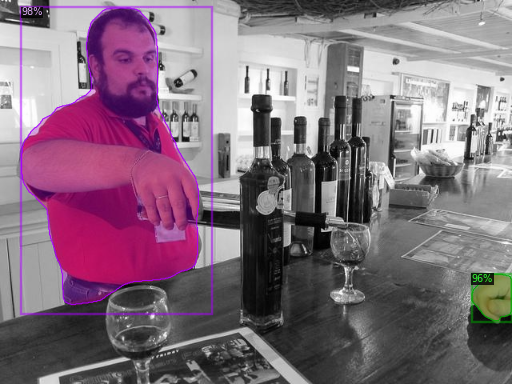

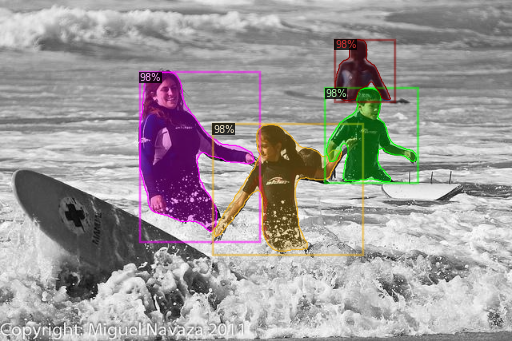

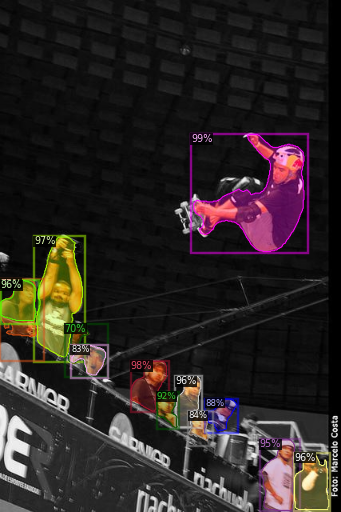

In [0]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=person_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

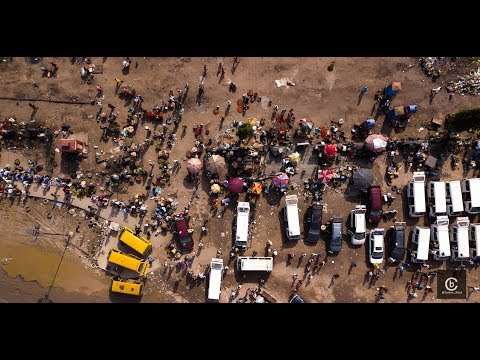

In [0]:
# This is the video we're going to process
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("CUVbEwS1gRA", width=500)
display(video)

In [0]:
# Install dependencies, download the video, and crop 5 seconds for processing
!pip install youtube-dl
!pip uninstall -y opencv-python opencv-contrib-python
!apt install python3-opencv  # the one pre-installed have some issues
!youtube-dl https://www.youtube.com/watch?v=CUVbEwS1gRA -f 22 -o video.mp4
!ffmpeg -i video.mp4 -t 00:00:35 -c:v copy video-clip.mp4

     |████████████████████████████████| 1.8MB 9.5MB/s 
Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
Uninstalling opencv-contrib-python-4.1.2.30:
  Successfully uninstalled opencv-contrib-python-4.1.2.30
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  python3-opencv
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 534 kB of archives.
After this operation, 2,941 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 python3-opencv amd64 3.2.0+dfsg-4ubuntu0.1 [534 kB]
Fetched 534 kB in 0s (6,109 kB/s)
Selecting previously unselected package python3-opencv.
(Reading database ... 144429 files and directories currently installed.)
Preparing to unpack .../python3-opencv_3.2.0+dfsg-4ubuntu0.1_amd64.deb ...
Unpacking python3-opencv (3.2.0+dfsg-4ubuntu0.1) ...
Setting up python3

In [0]:
# Run frame-by-frame inference demo on this video (takes 3-4 minutes)
# Using a model trained on COCO dataset
!git clone https://github.com/facebookresearch/detectron2

Cloning into 'detectron2'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 4745 (delta 2), reused 5 (delta 2), pack-reused 4730
Receiving objects: 100% (4745/4745), 2.39 MiB | 4.56 MiB/s, done.
Resolving deltas: 100% (3368/3368), done.


In [0]:
!python detectron2/demo/demo.py --config-file detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml --video-input video-clip.mp4 --confidence-threshold 0.6 --output video-output.mkv \
  --opts MODEL.WEIGHTS nn_R_50_FPN_3x/137849600/model_final_f10217.pkl

Failed to load OpenCL runtime
[05/12 11:38:59 detectron2]: Arguments: Namespace(confidence_threshold=0.6, config_file='/content/output/last_checkpoint', input=None, opts=['MODEL.WEIGHTS', '/content/output/model_final.pth'], output='video-output.mkv', video_input='video-clip.mp4', webcam=False)
Traceback (most recent call last):
  File "detectron2/demo/demo.py", line 77, in <module>
    cfg = setup_cfg(args)
  File "detectron2/demo/demo.py", line 23, in setup_cfg
    cfg.merge_from_file(args.config_file)
  File "/usr/local/lib/python3.6/dist-packages/detectron2/config/config.py", line 27, in merge_from_file
    loaded_cfg = type(self)(loaded_cfg)
  File "/usr/local/lib/python3.6/dist-packages/yacs/config.py", line 86, in __init__
    init_dict = self._create_config_tree_from_dict(init_dict, key_list)
  File "/usr/local/lib/python3.6/dist-packages/yacs/config.py", line 123, in _create_config_tree_from_dict
    for k, v in dic.items():
AttributeError: 'str' object has no attribute 'items'

In [0]:
# Download the results
from google.colab import files
files.download('video-output.mkv')

MessageError: ignored

In [0]:
# !pip install onnx
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import build_detection_test_loader
from detectron2.export import export_onnx_model
from detectron2.export import add_export_config
import onnx

from detectron2.modeling import build_model


def setup_cfg():
    cfg_config = add_export_config(cfg)
    cfg.freeze()
    if cfg.MODEL.DEVICE != "cpu":
        TORCH_VERSION = tuple(int(x) for x in torch.__version__.split(".")[:2])
        assert TORCH_VERSION >= (1, 5), "PyTorch>=1.5 required for GPU conversion!"
    return cfg


model = build_model(setup_cfg()) 
DetectionCheckpointer(model).resume_or_load(cfg.MODEL.WEIGHTS)

# get a sample data
data_loader = build_detection_test_loader(cfg, cfg.DATASETS.TRAIN[0])
first_batch = next(iter(data_loader))


onnx_model = export_onnx_model(cfg, model, first_batch )
onnx.save(onnx_model, os.path.join('./onnx_model/', "model.onnx"))

[05/12 11:29:08 d2.data.datasets.coco]: Loaded 2693 images in COCO format from /content/person_annotations.json
[05/12 11:29:09 d2.data.common]: Serializing 2693 elements to byte tensors and concatenating them all ...
[05/12 11:29:09 d2.data.common]: Serialized dataset takes 7.69 MiB


/usr/local/lib/python3.6/dist-packages/torch/onnx/utils.py:209: UserWarning: `add_node_names' can be set to True only when 'operator_export_type' is `ONNX`. Since 'operator_export_type' is not set to 'ONNX', `add_node_names` argument will be ignored.
  "`{}` argument will be ignored.".format(arg_name, arg_name))
/usr/local/lib/python3.6/dist-packages/torch/onnx/utils.py:209: UserWarning: `do_constant_folding' can be set to True only when 'operator_export_type' is `ONNX`. Since 'operator_export_type' is not set to 'ONNX', `do_constant_folding` argument will be ignored.
  "`{}` argument will be ignored.".format(arg_name, arg_name))
/usr/local/lib/python3.6/dist-packages/detectron2/export/c10.py:31: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert tensor.dim() == 2 an

In [0]:
cfg.MODEL.WEIGHTS

'/content/output/model_final.pth'